<a href="https://colab.research.google.com/github/kelvinfoo123/MH4500-Time-Series-Analysis/blob/main/Airplane_Ticket_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns 

import warnings 
warnings.filterwarnings('ignore')

In [9]:
airline = pd.read_csv("airline.txt", sep = ",", header = None)
airline.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [10]:
airline.columns = ['Month', 'Passengers']
airline['Month'] = pd.to_datetime(airline['Month'], format = '%Y-%m')
airline = airline.set_index('Month')
airline.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


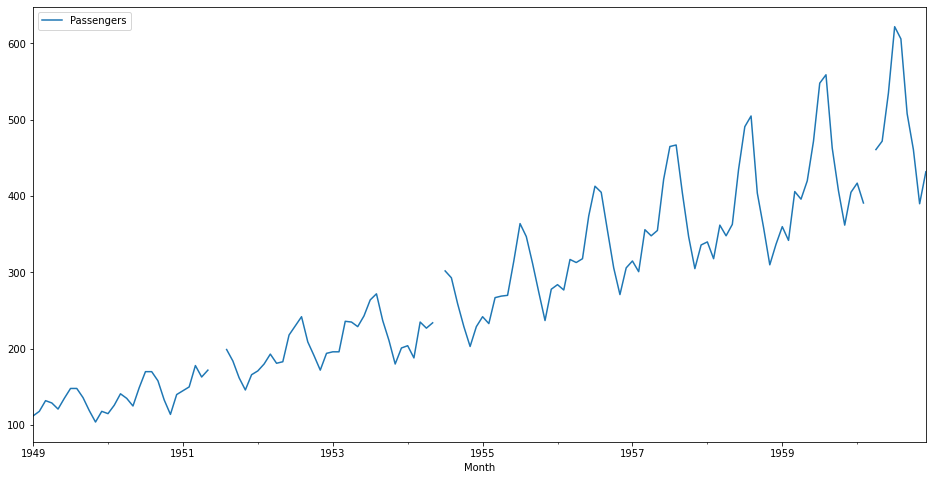

In [11]:
airline.plot(figsize = (16,8))

- Notice that there are some missing values.

## **Handling missing values**
**We use the linear interpolation method to handle the missing values. The linear interpolation method joins a straight line between the next and previous points of the missing value in the data.**

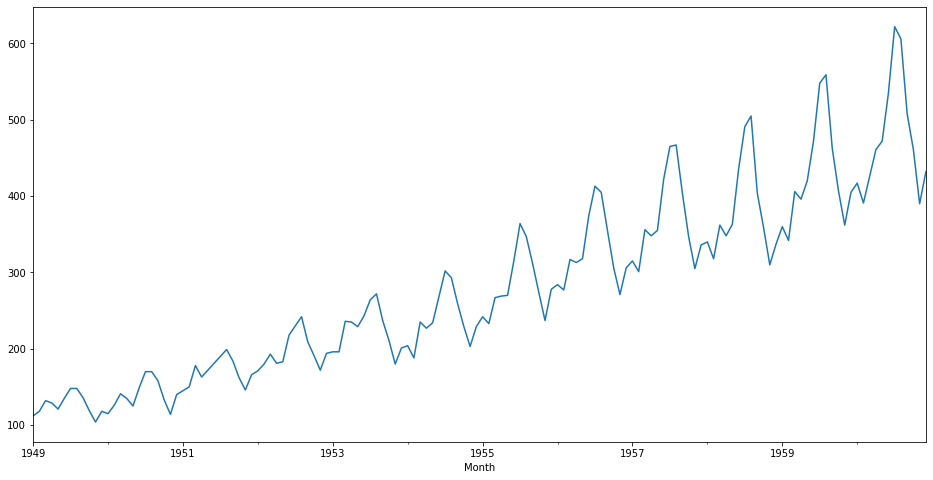

In [12]:
airline = airline.assign(new_passengers = airline['Passengers'].interpolate(method = 'linear'))
airline['new_passengers'].plot(figsize = (16,8))

In [16]:
# Replacing passengers with linear interpolation values for passengers 

airline = airline.drop(['Passengers'], axis = 1)
airline.rename(columns = {'new_passengers': 'Passengers'}, inplace = True)
airline.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## **Time Series Decomposition**

**Additive Seasonal Decomposition**

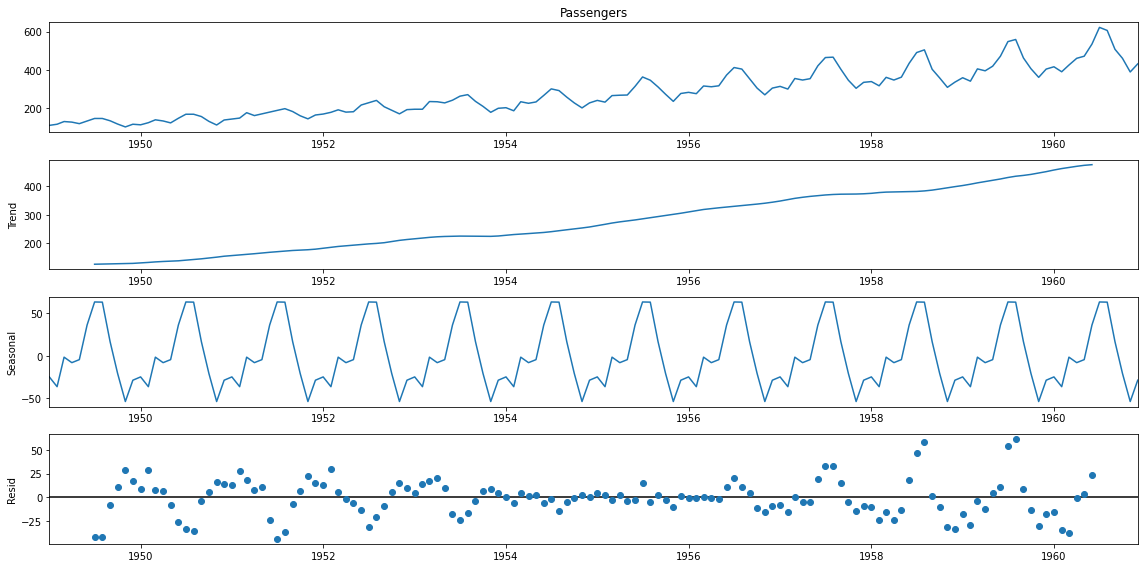

In [21]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

decomposition = sm.tsa.seasonal_decompose(airline['Passengers'], model = 'additive')
fig = decomposition.plot()
plt.show()

**Mulitiplicative Seasonal Decomposition**

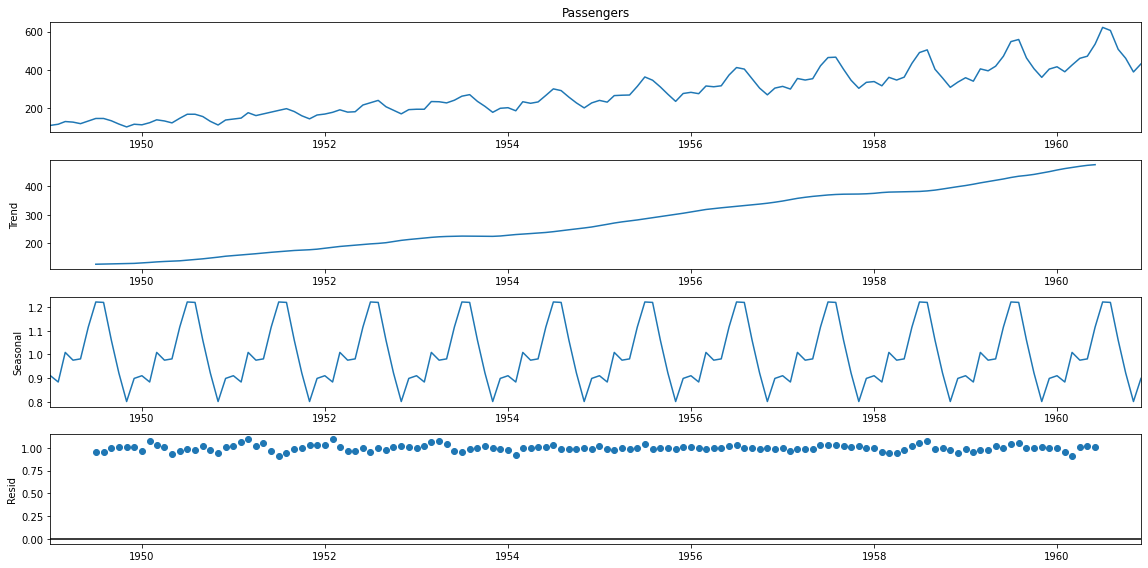

In [24]:
decomposition = sm.tsa.seasonal_decompose(airline['Passengers'], model = 'multiplicative')
fig = decomposition.plot()
plt.show()

## **Training and Test Set**

**The test set will comprise of values for 1959 and 1960. The aim is to forecast passenger counts for these two years.**

In [74]:
train = airline[:-24]
test = airline[-24:]

train.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [26]:
test.head()

,Passengers
Month,
1959-01-01,360.0
1959-02-01,342.0
1959-03-01,406.0
1959-04-01,396.0
1959-05-01,420.0


## **Summary of Forecasting Methods**
- Simple moving average
- Exponential smoothing
- Auto regressive (AR)
- Moving average (MA)
- Auto regressive moving average (ARMA)
- Seasonal auto regressive integrated moving average (SARIMA)

## **Simple Moving Average**
**Takes the average of the last few observations to forecast the future.**

In [28]:
y_sma = airline.copy()

window = 12 # Taking average over the last 12 months 

y_sma['forecast'] = airline['Passengers'].rolling(window).mean()
y_sma['forecast'][-24:] = y_sma['forecast'][119]

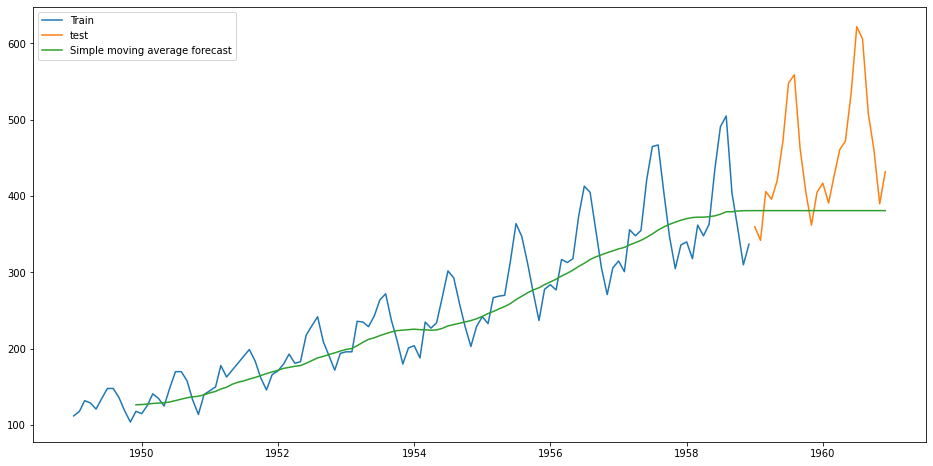

In [29]:
plt.figure(figsize = (16,8))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_sma['forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.show()

- The simple moving average model captures the trend but not the seasonality. It is not a good model. 

In [33]:
from sklearn.metrics import mean_squared_error 

rmse = np.sqrt(mean_squared_error(test['Passengers'], y_sma['forecast'][-24:])).round(2)
results = []
results = pd.DataFrame({'Method': ['Simple Moving Average'], 'RMSE': [rmse]})
results

,Method,RMSE
0,Simple Moving Average,103.33


## **Holt-Winter's Exponential Smoothing**
**We know that the airline data has trend and seasonal factors. Hence, we forecast using Holt-Winter's expoenetial smoothing which captures trend and seasonal factors.**

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

**Additive Method**

In [34]:
y_hat = test.copy()

In [36]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12, trend = 'additive', seasonal = 'additive')
model_fit = model.fit(optimized = True)

y_hat['forecast'] = model_fit.forecast(24) # Forecast for last 24 months 

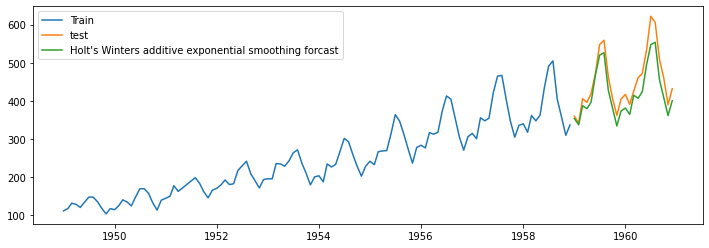

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat['forecast'], label='Holt\'s Winters additive exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [39]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'])).round(2)
results = results.append({'Method':'Holt\'s Winter additive method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87


**Multiplicative Method**

In [40]:
y_hat = test.copy()

In [43]:
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods = 12, trend = 'additive', seasonal = 'multiplicative')
model_fit = model.fit(optimized = True)

y_hat['forecast'] = model_fit.forecast(24)

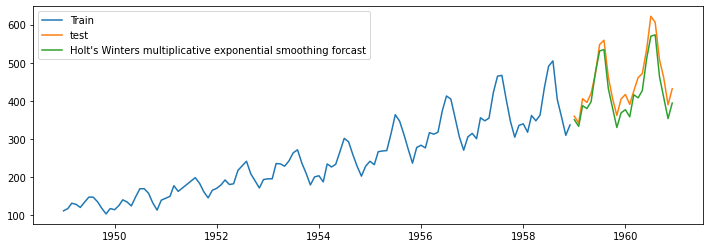

In [44]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='test')
plt.plot(y_hat['forecast'], label='Holt\'s Winters multiplicative exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [45]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'])).round(2)
results = results.append({'Method':'Holt\'s Winter multiplicative method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87
2,Holt's Winter multiplicative method,32.46


## **Check for Stationarity**

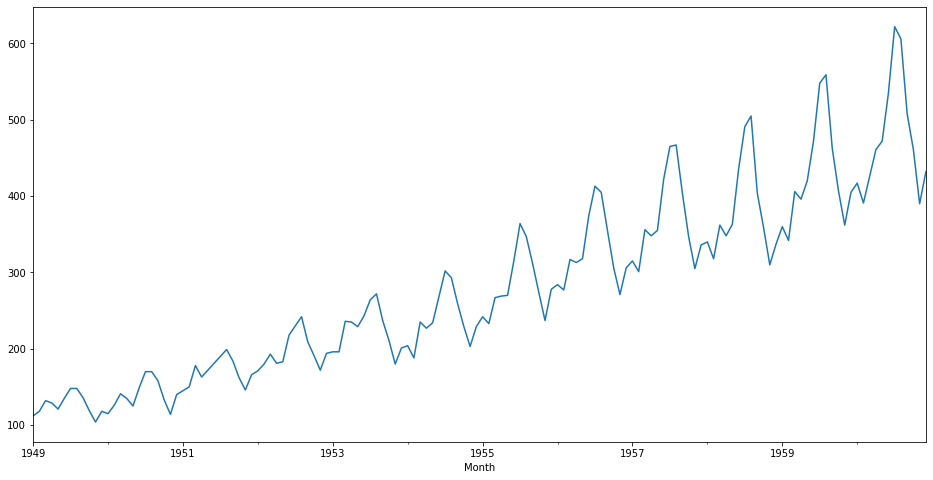

In [47]:
airline['Passengers'].plot(figsize = (16,8))

- The data is not stationary since there is an increasing trend and seasonality. We verify this using the augmented dicky-fuller test.

In [49]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(airline['Passengers'])

In [50]:
print('p-value: %f' %adf_test[1])

p-value: 0.993020


- Since the p-value > 0.05, we cannot reject the null hypothesis and thus, the time series is non-stationary. 

## **Convert non-stationary to stationary time series**

**Box Cox Transformation**
- Makes the variance constant in a series.

In [51]:
from scipy.stats import boxcox

In [53]:
airline_boxcox = pd.Series(boxcox(airline['Passengers'], lmbda = 0), airline.index)

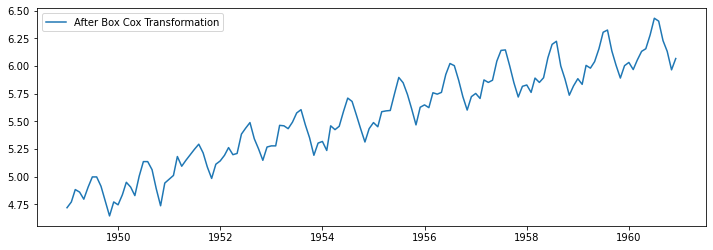

In [54]:
plt.figure(figsize=(12,4))
plt.plot(airline_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.show()

- Variance is now constant but trend and seasonality is still there. 
- We remove the trend and seasonality by differencing. 

**Differencing**
- Subtracts previous observations from current observations

In [56]:
airline_boxcox_diff = pd.Series(airline_boxcox - airline_boxcox.shift(), index = airline.index)

# The first record will be null. We remove it. 
airline_boxcox_diff.dropna(inplace = True)

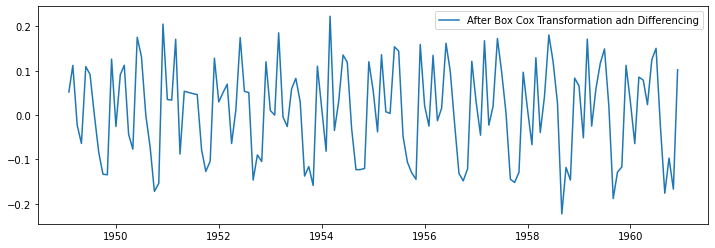

In [57]:
plt.figure(figsize=(12,4))
plt.plot(airline_boxcox_diff, label='After Box Cox Transformation adn Differencing')
plt.legend(loc='best')
plt.show()

- There is no more trend and seasonality.

In [58]:
adf_test = adfuller(airline_boxcox_diff)
print('p-value: %f' %adf_test[1])

p-value: 0.015326


- By ADF test, since p-value < 0.05, the time series is stationary.

## **ACF and PACF**

**ACF**
- captures both direct and indirect relationship with its lagged values.

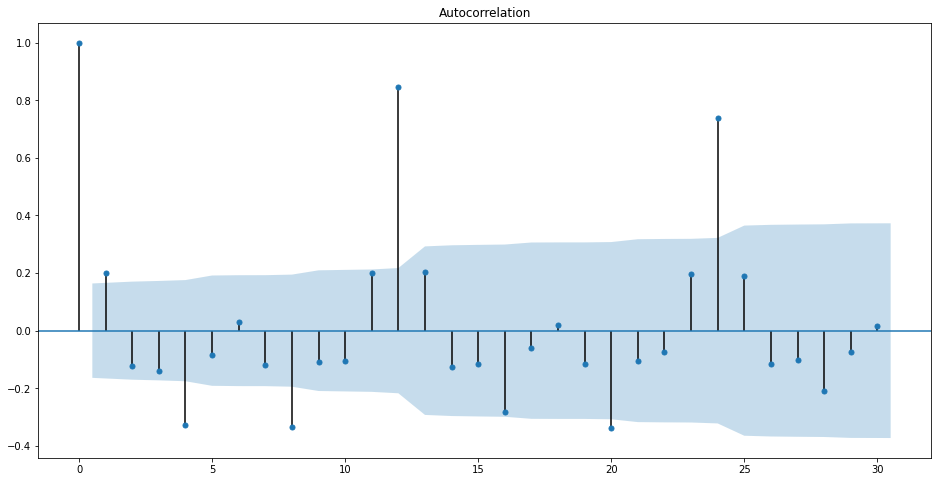

In [60]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize = (16,8))
plot_acf(airline_boxcox_diff, ax = plt.gca(), lags = 30)
plt.show()

**PACF**
- Captures direct relationship with lagged values.

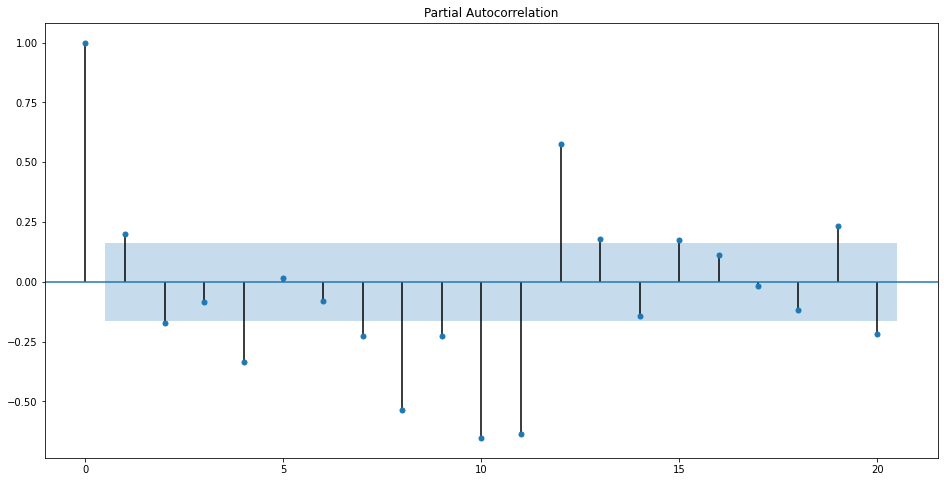

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf 

plt.figure(figsize = (16,8))
plot_pacf(airline_boxcox_diff, ax = plt.gca(), lags = 20)
plt.show()

## **Training and test set**

In [73]:
# 119 since first observation is removed 

train_new = airline_boxcox_diff[:119]
test_new = airline_boxcox_diff[119:]

## **AR Model**

In [64]:
from statsmodels.tsa.arima_model import ARIMA 

In [77]:
model = ARIMA(train_new, order = (1,0,0))
model_fit = model.fit()

In [66]:
y_hat = airline_boxcox_diff.copy()

In [68]:
# Predict for all time steps 
y_hat['forecast_boxcox_diff'] = model_fit.predict(airline_boxcox_diff.index.min(), airline_boxcox_diff.index.max())

**Reverse the stationary time series to become non-stationary**

In [70]:
# Reverse differencing and add back the first term 
y_hat['forecast_boxcox'] = y_hat['forecast_boxcox_diff'].cumsum().add(airline_boxcox[0])

In [71]:
# Reverse box cox transformation 
y_hat['forecast'] = np.exp(y_hat['forecast_boxcox'])

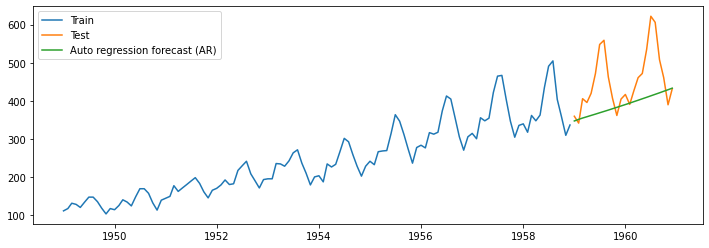

In [75]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat['forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [76]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'][test.index.min():])).round(2)

results = results.append({'Method':'Auto regressive (AR) method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87
2,Holt's Winter multiplicative method,32.46
3,Auto regressive (AR) method,93.39


## **MA Model**

In [78]:
model = ARIMA(train_new, order = (0,0,1))
model_fit = model.fit()

In [79]:
y_hat = airline_boxcox_diff.copy()

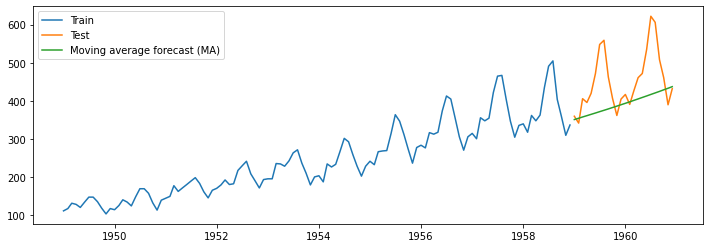

In [80]:
y_hat['forecast_boxcox_diff'] = model_fit.predict(airline_boxcox_diff.index.min(), airline_boxcox_diff.index.max())
y_hat['forecast_boxcox'] = y_hat['forecast_boxcox_diff'].cumsum().add(airline_boxcox[0])
y_hat['forecast'] = np.exp(y_hat['forecast_boxcox'])

plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat['forecast'][test.index.min():], label='Moving average forecast (MA)')
plt.legend(loc='best')
plt.show()

In [81]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'][test.index.min():])).round(2)
results = results.append({'Method':'Moving average (MA) method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87
2,Holt's Winter multiplicative method,32.46
3,Auto regressive (AR) method,93.39
4,Moving average (MA) method,91.21


## **ARMA Model**

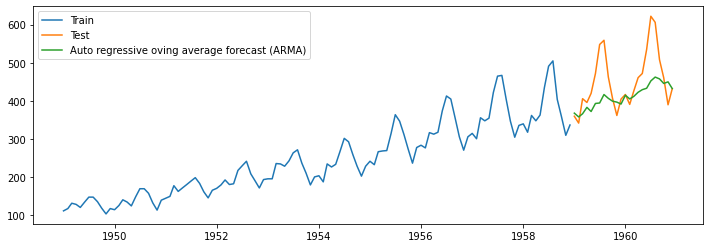

In [82]:
model = ARIMA(airline_boxcox_diff, order = (1,0,1))
model_fit = model.fit()

y_hat = airline_boxcox_diff.copy()
y_hat['forecast_boxcox_diff'] = model_fit.predict(airline_boxcox_diff.index.min(), airline_boxcox_diff.index.max())
y_hat['forecast_boxcox'] = y_hat['forecast_boxcox_diff'].cumsum().add(airline_boxcox[0])
y_hat['forecast'] = np.exp(y_hat['forecast_boxcox'])

plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat['forecast'][test.index.min():], label='Auto regressive oving average forecast (ARMA)')
plt.legend(loc='best')
plt.show()

In [83]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'][test.index.min():])).round(2)

results = results.append({'Method':'Auto regressive moving average (ARMA) method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87
2,Holt's Winter multiplicative method,32.46
3,Auto regressive (AR) method,93.39
4,Moving average (MA) method,91.21
5,Auto regressive moving average (ARMA) method,73.16


## **SARIMA Model**
- ARIMA performs differencing automatically if the series has trend. Hence, there is no need to perform differencing manually.
- SARIMA is ARIMA with seasonal components.

In [84]:
# New training and test set without differencing

train_new = airline_boxcox[:-24]
test_new = airline_boxcox[-24:]

In [85]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [86]:
model = SARIMAX(train_new, order = (1,1,1), seasonal_order = (1, 1, 1, 12))
model_fit = model.fit()

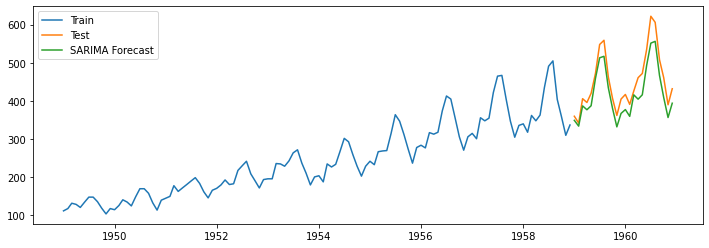

In [87]:
# Compare with the differenced time series since SARIMA perform differencing automatically 
y_hat = airline_boxcox_diff.copy()
y_hat['forecast_boxcox'] = model_fit.predict(airline_boxcox_diff.index.min(), airline_boxcox_diff.index.max()) # Returns non-differenced values 

# When using ARIMA, we don't need to reverse the differencing. We just reverse the box cox. 
y_hat['forecast'] = np.exp(y_hat['forecast_boxcox'])

plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat['forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [88]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat['forecast'][test.index.min():])).round(2)

results = results.append({'Method':'SARIMA method', 'RMSE':rmse}, ignore_index=True)
results

,Method,RMSE
0,Simple Moving Average,103.33
1,Holt's Winter additive method,35.87
2,Holt's Winter multiplicative method,32.46
3,Auto regressive (AR) method,93.39
4,Moving average (MA) method,91.21
5,Auto regressive moving average (ARMA) method,73.16
6,SARIMA method,37.62


- The best models are Holt's winter method and SARIMA method since they capture seasonality. 